In [1]:
using Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ayats\Documents\aeer-parsing`


In [2]:
import CSV as CSV
import DataFrames: DataFrame
import DataFrames as DataFrames
using Printf
using Dates, DataFramesMeta

header = ["year","day","datetm","min","ws_25","wd_25","tp_25","ws_50","wd_50","tp_50","missing"]
header_dqc = ["year","day","datetm","min","ws_25_dqc","wd_25_dqc","tp_25_dqc","ws_50_dqc","wd_50_dqc","tp_50_dqc","missing"]
dfs=Any[]

for month = 1:12
    monthstr = @sprintf "%02d" month

    df = CSV.read(
        "./data/ORN09$(monthstr)WD.csv", DataFrame;
        header=header, 
        delim=';',
        dateformat="yyyy-mm-dd HH:MM:SS",
        drop=[:missing, :min],
        silencewarnings=true,
        types=Dict(
            :ws_25 => Float64,
            :ws_50 => Float64,
            :tp_25 => Float64,
            :tp_50 => Float64
        )
    )

    df_dqc = CSV.read(
        "./data/ORN09$(monthstr)WD_DQC.csv", DataFrame;
        header=header_dqc, 
        delim=';',
        dateformat="yyyy-mm-dd HH:MM:SS",
        silencewarnings=true,
        drop=[:year, :day, :min, :missing],
        types=Dict(
            :ws_25_dqc => Int64,
            :ws_50_dqc => Int64,
            :tp_25_dqc => Int64,
            :tp_50_dqc => Int64
        )
    )

    result = DataFrames.innerjoin(df, df_dqc, on=:datetm)

    push!(dfs, result)
end


data = reduce(vcat, dfs)
@transform!(data, @byrow :month = Dates.month(:datetm))

Row,year,day,datetm,ws_25,wd_25,tp_25,ws_50,wd_50,tp_50,ws_25_dqc,wd_25_dqc,tp_25_dqc,ws_50_dqc,wd_50_dqc,tp_50_dqc,month
,Int64,Int64,DateTime,Float64?,Any,Float64?,Float64?,Any,Float64?,Int64?,Any,Int64?,Int64?,Any,Int64?,Int64
1,2009,1,2009-01-01T00:00:00,2.241,328.0,24.64,3.571,322.1,25.54,9999,999,999,9999,999,999,1
2,2009,1,2009-01-01T00:10:00,2.386,351.4,24.29,3.29,342.0,24.96,9999,999,999,9999,999,999,1
3,2009,1,2009-01-01T00:20:00,1.907,355.1,24.19,2.996,341.3,25.07,9999,999,999,9999,999,999,1
4,2009,1,2009-01-01T00:30:00,1.113,84.9,24.24,1.613,0.517,25.16,9999,999,999,9999,999,999,1
5,2009,1,2009-01-01T00:40:00,4.031,173.4,24.76,4.694,177.7,25.18,9999,999,999,9999,999,999,1
6,2009,1,2009-01-01T00:50:00,1.185,241.9,25.97,1.447,198.3,25.98,9999,999,999,9999,999,999,1
7,2009,1,2009-01-01T01:00:00,1.727,56.83,25.16,2.488,90.4,25.04,9999,999,999,9999,999,999,1
8,2009,1,2009-01-01T01:10:00,2.053,32.83,25.48,1.88,49.17,25.78,9999,999,999,2999,999,999,1
9,2009,1,2009-01-01T01:20:00,1.76,27.14,25.32,2.135,47.11,25.96,9999,999,999,9999,999,999,1


In [3]:
println(varinfo(r"^data$"))

| name |      size | summary            |
|:---- | ---------:|:------------------ |
| data | 8.383 MiB | 52848×16 DataFrame |



In [4]:
using Statistics

monthly = DataFrame(month = 1:12)

(@chain data begin
    @subset(:ws_50_dqc .== 9999)
    @by(:month, :ws_50_mean = mean(:ws_50))
end) |> x -> DataFrames.leftjoin!(monthly, x, on=:month)

(@chain data begin
    @subset(:ws_25_dqc .== 9999)
    @by(:month, :ws_25_mean = mean(:ws_25))
end) |> x -> DataFrames.leftjoin!(monthly, x, on=:month)

(@chain data begin
    @subset(:tp_25_dqc .== 999)
    @by(:month, :tp_25_mean = mean(:tp_25))
end) |> x -> DataFrames.leftjoin!(monthly, x, on=:month)

(@chain data begin
    @subset(:tp_50_dqc .== 999)
    @by(:month, :tp_50_mean = mean(:tp_50))
end) |> x -> DataFrames.leftjoin!(monthly, x, on=:month)

@chain monthly begin
    @transform!(@byrow :month_name = Dates.monthname(:month))
end

Row,month,ws_50_mean,ws_25_mean,tp_25_mean,tp_50_mean,month_name
,Int64,Float64?,Float64?,Float64?,Float64?,String
1,1,3.88734,2.61814,19.3855,23.09,January
2,2,3.43618,2.30857,missing,24.8125,February
3,3,3.42871,2.30462,missing,25.0458,March
4,4,3.68556,2.44093,missing,22.8784,April
5,5,3.48716,2.23502,missing,20.3402,May
6,6,3.43731,2.15174,missing,16.6248,June
7,7,3.5275,2.58375,-74.5692,18.0379,July
8,8,3.96033,5.43076,-74.3,19.5458,August
9,9,4.00856,7.89924,-74.1,21.8758,September


Weibull{Float64}(α=1.3084505747802564, θ=3.1280280982378392)

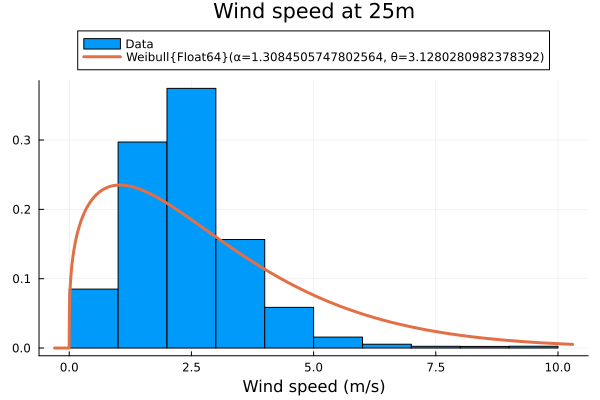

In [8]:
using Distributions

dist = (@chain data begin
    @subset(:ws_25_dqc .== 9999)
    @select(:ws_25)
end) |> 
    DataFrames.dropmissing |> 
    x -> x[!, 1] |>
    x -> fit(Weibull{Float64}, x)

display(dist)

using StatsPlots

ys = collect(0:1:10)

(@chain data begin
    @subset(:ws_25_dqc .== 9999)
    @select(:ws_25)
end) |> @df histogram(:ws_25, bins=ys, normalize=:pdf, label="Data")

plot!(x -> pdf(dist, x), linewidth = 3, label=repr(dist), legend=:outertop)
title!("Wind speed at 25m")
xlabel!("Wind speed (m/s)")

Weibull{Float64}(α=2.397055250191823, θ=4.136019009554779)

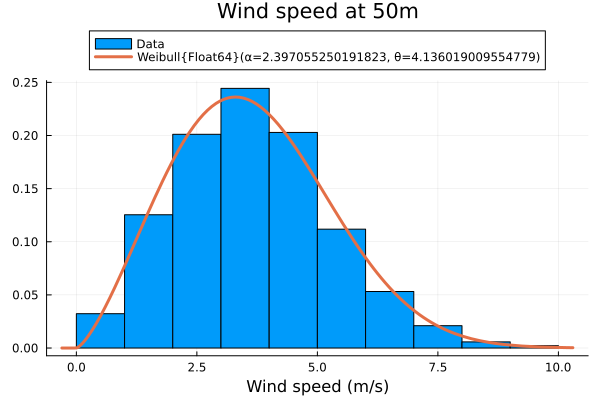

In [7]:
dist = (@chain data begin
    @subset(:ws_50_dqc .== 9999)
    @select(:ws_50)
end) |> 
    DataFrames.dropmissing |> 
    x -> x[!, 1] |>
    x -> fit(Weibull{Float64}, x)

display(dist)

using StatsPlots

ys = collect(0:1:10)

(@chain data begin
    @subset(:ws_50_dqc .== 9999)
    @select(:ws_50)
end) |> @df histogram(:ws_50, bins=ys, normalize=:pdf, label="Data")

plot!(x -> pdf(dist, x), linewidth = 3, label=repr(dist), legend=:outertop)
title!("Wind speed at 50m")
xlabel!("Wind speed (m/s)")